In [1]:
#Load neccesary packages
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from scipy import stats
from scipy.stats import skew, boxcox_normmax, norm
from scipy.special import boxcox1p

from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler, Normalizer
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error

from mlxtend.regressor import StackingCVRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [2]:
#Load and inspect train-test datas
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
print('Train set size:', train.shape)
print('Test set size:', test.shape)

Train set size: (1460, 81)
Test set size: (1459, 80)


In [3]:
display(train.sample(5))
display(test.sample(5))

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1368,1369,120,RM,NaN,4435,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2009,WD,Normal,144000
852,853,75,RL,53.0,7128,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,8,2007,WD,Normal,164000
908,909,20,RL,NaN,8885,Pave,NaN,IR1,Low,AllPub,...,0,NaN,MnPrv,NaN,0,6,2006,WD,Normal,131000
470,471,120,RL,NaN,6820,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2010,WD,Normal,212000
460,461,60,FV,75.0,8004,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2009,New,Partial,263435


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
876,2337,20,RL,75.0,9910,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2007,New,Partial
179,1640,60,RL,NaN,12388,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,8,2009,WD,Normal
846,2307,120,RL,41.0,6289,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2007,WD,Normal
943,2404,85,RL,NaN,10050,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2007,WD,Normal
545,2006,20,FV,72.0,8640,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,7,2008,New,Partial


In [4]:
#Dropping not needed columns from both datasets
train.drop(['Id'], axis=1, inplace=True)
test.drop(['Id'], axis=1, inplace=True)

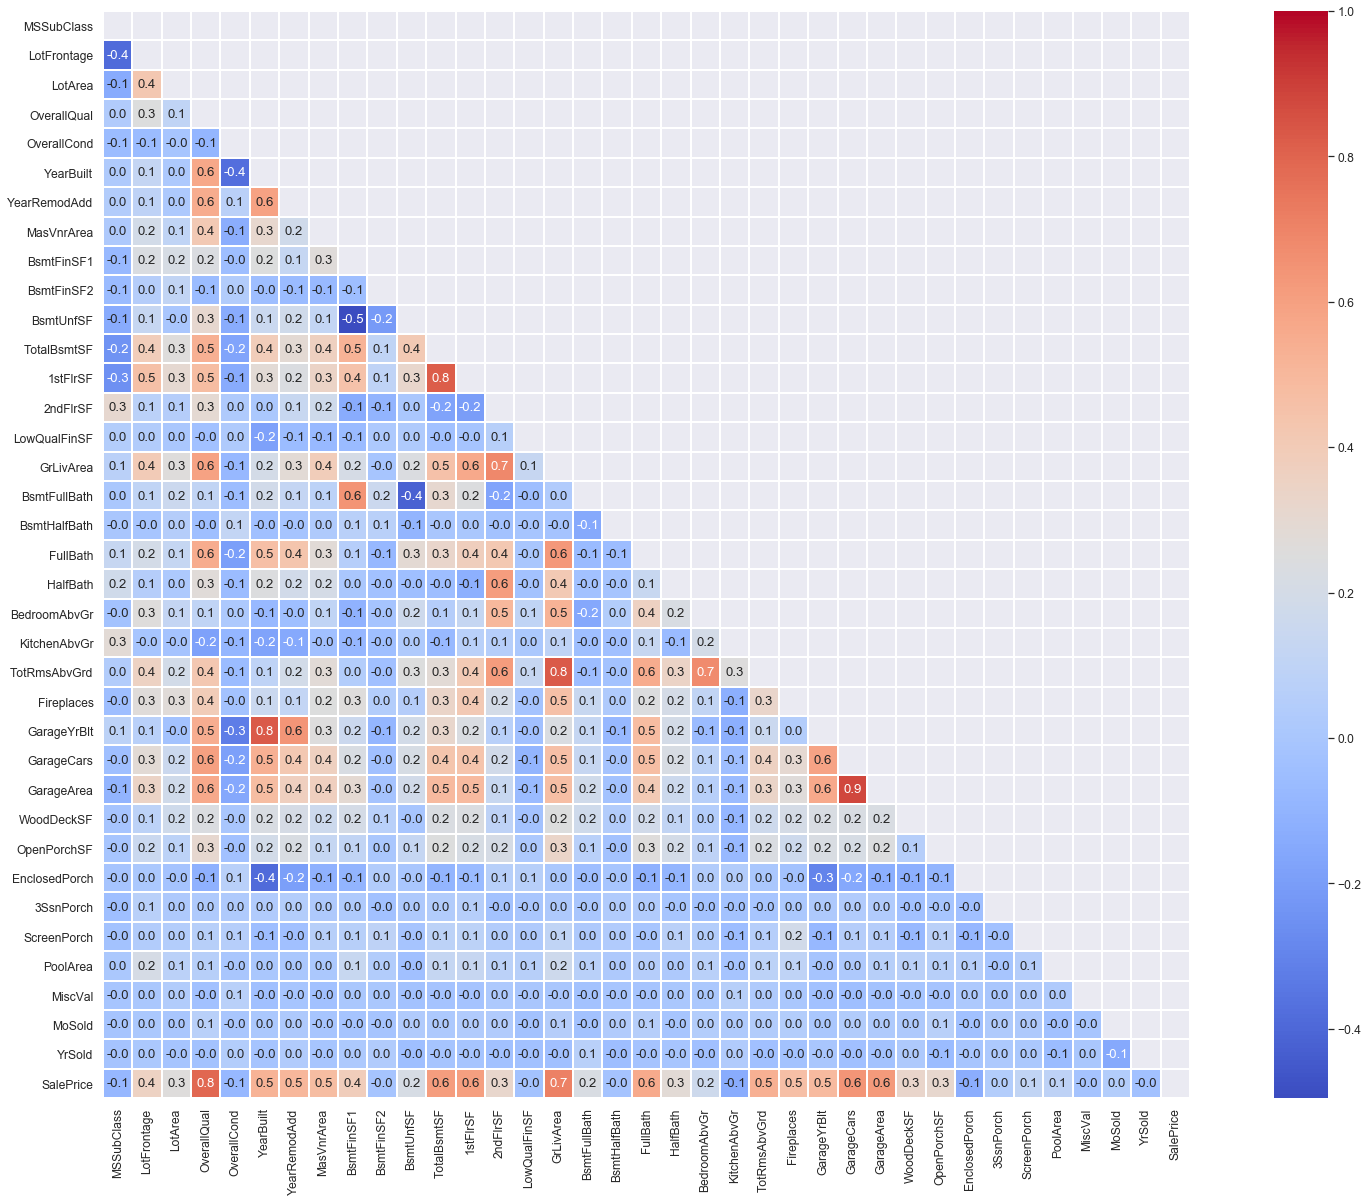

In [5]:
#Display numerical correlations between features on heatmap
sns.set(font_scale=1.1)
correlation_train = train.corr()
mask = np.triu(correlation_train.corr())
plt.figure(figsize=(30, 20))
sns.heatmap(correlation_train,
            annot=True,
            fmt='.1f',
            cmap='coolwarm',
            square=True,
            mask=mask,
            linewidths=1)

plt.show()

In [6]:
#Listing most related numerical features to target.
train_corr = train.corr().abs().unstack().sort_values(
    kind='quicksort', ascending=False).reset_index()
train_corr.rename(columns={
    'level_0': 'Feature A',
    'level_1': 'Feature B',
    0: 'Correlation Coefficient'
},
    inplace=True)
train_corr[(train_corr['Feature A'] == 'SalePrice') & (
    train_corr['Correlation Coefficient'] >= 0.5)].style.background_gradient(
        cmap='summer_r')

,Feature A,Feature B,Correlation Coefficient
0,SalePrice,SalePrice,1.000000
45,SalePrice,OverallQual,0.790982
48,SalePrice,GrLivArea,0.708624
58,SalePrice,GarageCars,0.640409
61,SalePrice,GarageArea,0.623431
66,SalePrice,TotalBsmtSF,0.613581
70,SalePrice,1stFlrSF,0.605852
87,SalePrice,FullBath,0.560664
102,SalePrice,TotRmsAbvGrd,0.533723
103,SalePrice,YearBuilt,0.522897


In [7]:
#Backing up target variables and dropping them from train data
y = train.SalePrice.reset_index(drop=True)
train_features = train.drop(['SalePrice'], axis=1)
test_features = test

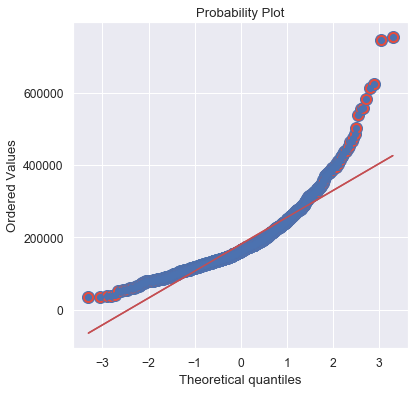

In [8]:
#Showing empirical target data set vs theororetical set
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
res = stats.probplot(train['SalePrice'], plot=plt)
# Plotting the QQ_Plot. 
stats.probplot(train['SalePrice'], plot = plt)
ax.get_lines()[0].set_markerfacecolor('#e74c3c')
ax.get_lines()[0].set_markersize(12.0)
plt.show()

In [9]:
#Merging train and test sets before engineering features for both.
features = pd.concat([train_features, test_features]).reset_index(drop=True)
print(features.shape)

(2919, 79)


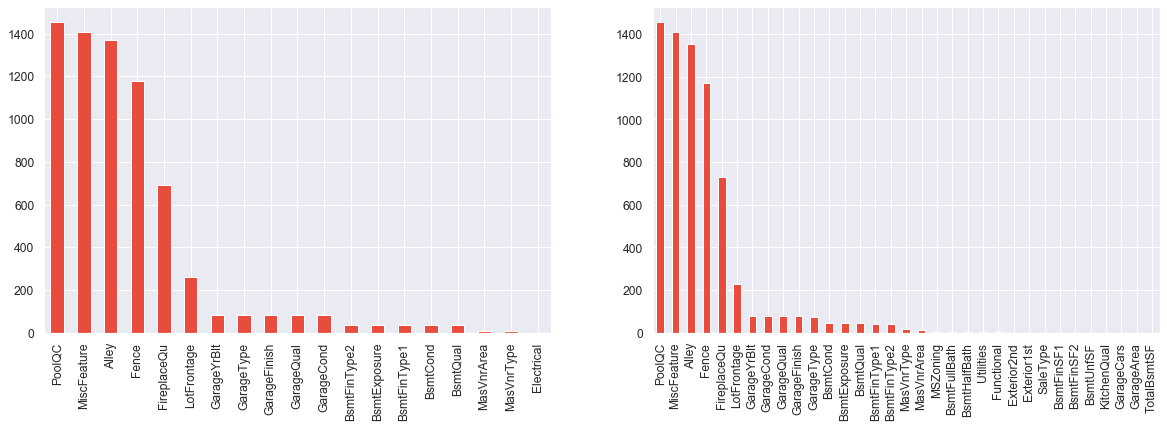

In [10]:
#Barplot of missing values on both sets.
fig, ax = plt.subplots(ncols=2, figsize=(20,6))
missing_tr = train.isnull().sum()
missing_te = test.isnull().sum()
missing_tr = missing_tr[missing_tr > 0]
missing_te = missing_te[missing_te > 0]
missing_tr.sort_values(ascending=False).plot(kind='bar', color='#e74c3c', ax=ax[0])
missing_te.sort_values(ascending=False).plot(kind='bar', color='#e74c3c', ax=ax[1])

In [11]:
#List of NaN including columns where NaN's mean none.
none_cols = [
    'Alley', 'PoolQC', 'MiscFeature', 'Fence', 'FireplaceQu', 'GarageType',
    'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond',
    'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType'
]
#List of NaN including columns where NaN's mean 0.
zero_cols = [
    'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath',
    'BsmtHalfBath', 'GarageYrBlt', 'GarageArea', 'GarageCars', 'MasVnrArea'
]

#List of NaN including columns where NaN's actually missing gonna replaced with mode.
freq_cols = [
    'Electrical', 'Exterior1st', 'Exterior2nd', 'Functional', 'KitchenQual',
    'SaleType', 'Utilities'
]
#Filling the list of columns above:
for col in zero_cols:
    features[col].replace(np.nan, 0, inplace=True)

for col in none_cols:
    features[col].replace(np.nan, 'None', inplace=True)

for col in freq_cols:
    features[col].replace(np.nan, features[col].mode()[0], inplace=True)

#Filling MSZoning with using related MSSubClass and mode:    
features['MSZoning'] = features.groupby('MSSubClass')['MSZoning'].transform(
    lambda x: x.fillna(x.mode()[0]))

#Features which numerical on data but should be treated as category.
features['MSSubClass'] = features['MSSubClass'].astype(str)
features['YrSold'] = features['YrSold'].astype(str)
features['MoSold'] = features['MoSold'].astype(str)



In [12]:
#Setting train and test sets for filling LotFrontage using SVR
lot_train = features[features['LotFrontage'].notnull()]
lot_test = features[features['LotFrontage'].isnull()]

#Checking test and train values
lot_target = lot_train['LotFrontage']
print(f'LotFrontage has {lot_test.shape[0]} missing value, and {lot_train.shape[0]} values available.')

LotFrontage has 486 missing value, and 2433 values available.


In [13]:
#Basic function to spot outliers
def idOutliers(dat):
    qtile25 = dat.quantile(q=0.25)
    qtile75 = dat.quantile(q=0.75)
    iqr = qtile75 - qtile25
    out = (dat > qtile75 + 1.5 * iqr) | (dat < qtile25 - 1.5 * iqr)
    return out

[Text(0.5, 0, 'sqrt(LotArea)')]

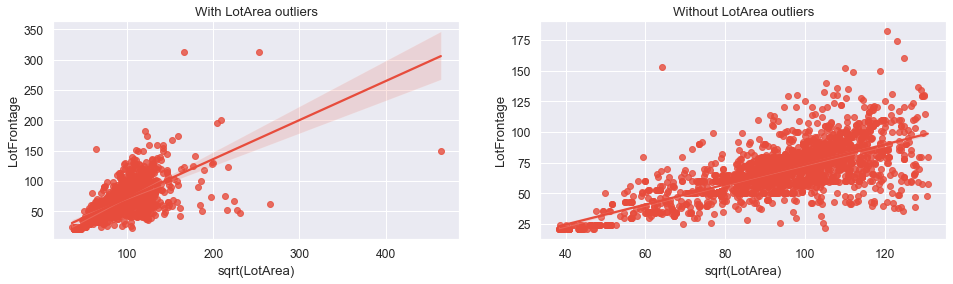

In [14]:
#LotArea with outliers vs. LotArea without outliers
fig, ax = plt.subplots(ncols=2, figsize=(16, 4))
ax[0].set_title('With LotArea outliers')
ax[1].set_title('Without LotArea outliers')
sns.regplot(lot_train.LotArea.apply(np.sqrt), lot_target, ax=ax[0],color='#e74c3c')
ax[0].set(xlabel='sqrt(LotArea)')
sns.regplot(lot_train.LotArea[~idOutliers(lot_train.LotArea)].apply(np.sqrt),
            lot_target[~idOutliers(lot_train.LotArea)],
            ax=ax[1],color='#e74c3c')
ax[1].set(xlabel='sqrt(LotArea)')

In [15]:
#Listing related numerical features of lot_train set
lot_train_corr = lot_train.corr().abs().unstack().sort_values(
    kind='quicksort', ascending=False).reset_index()
lot_train_corr.rename(columns={
    'level_0': 'Feature A',
    'level_1': 'Feature B',
    0: 'Correlation Coefficient'
},
    inplace=True)
lot_train_corr[(lot_train_corr['Feature A'] == 'LotFrontage') & (
    lot_train_corr['Correlation Coefficient'] >= 0.3)].style.background_gradient(
        cmap='summer_r')

,Feature A,Feature B,Correlation Coefficient
32,LotFrontage,LotFrontage,1.000000
94,LotFrontage,LotArea,0.489896
114,LotFrontage,1stFlrSF,0.458247
158,LotFrontage,GrLivArea,0.382462
165,LotFrontage,GarageArea,0.360124
170,LotFrontage,TotalBsmtSF,0.353090
171,LotFrontage,TotRmsAbvGrd,0.349513
203,LotFrontage,GarageCars,0.310984


In [16]:
#Deciding target and train variables for svr model.
y_lotFrontage = lot_train['LotFrontage']
X_lot_train = lot_train.loc[:, [
    'LotArea', 'LotConfig', 'LotShape', 'Alley', 'MSZoning', 'BldgType',
    'Neighborhood', 'Condition1', 'Condition2', 'GarageCars', '1stFlrSF', 'GrLivArea', 'MSSubClass'
]]

#Getting dummy variables
X_lot_train = pd.get_dummies(X_lot_train)
#Normalization of train data
X_lot_train = (X_lot_train - X_lot_train.mean()) / X_lot_train.std()

In [17]:
clf = SVR(kernel='rbf', C=100, gamma=0.003)

acc = 0
acc1 = 0
acc2 = 0

kf = KFold(n_splits=10, shuffle=True, random_state=42)

for trn, tst in kf.split(lot_train):

    # Compute benchmark score prediction based on mean neighbourhood LotFrontage
    fold_train_samples = lot_train.iloc[trn]
    fold_test_samples = lot_train.iloc[tst]
    neigh_means = fold_train_samples.groupby(
        'Neighborhood')['LotFrontage'].mean()
    all_mean = fold_train_samples['LotFrontage'].mean()
    y_pred_neigh_means = fold_test_samples.join(
        neigh_means, on='Neighborhood', lsuffix='benchmark')['LotFrontage']
    y_pred_all_mean = [all_mean] * fold_test_samples.shape[0]

    # Compute benchmark score prediction based on overall mean LotFrontage
    u1 = ((fold_test_samples['LotFrontage'] - y_pred_neigh_means)**2).sum()
    u2 = ((fold_test_samples['LotFrontage'] - y_pred_all_mean)**2).sum()
    v = ((fold_test_samples['LotFrontage'] -
          fold_test_samples['LotFrontage'].mean())**2).sum()

    # Perform model fitting
    clf.fit(X_lot_train.iloc[trn], y_lotFrontage.iloc[trn])

    # Record all scores for averaging
    acc = acc + mean_absolute_error(fold_test_samples['LotFrontage'],
                                    clf.predict(X_lot_train.iloc[tst]))
    acc1 = acc1 + mean_absolute_error(fold_test_samples['LotFrontage'],
                                      y_pred_neigh_means)
    acc2 = acc2 + mean_absolute_error(fold_test_samples['LotFrontage'],
                                      y_pred_all_mean)

print('10-Fold Validation Mean Absolute Error results:')
print('\tSVR: {:.3}'.format(acc / 10))
print('\tSingle mean: {:.3}'.format(acc2 / 10))
print('\tNeighbourhood mean: {:.3}'.format(acc1 / 10))

10-Fold Validation Mean Absolute Error results:
	SVR: 8.02
	Single mean: 16.6
	Neighbourhood mean: 13.2


In [18]:
X_lot_test = lot_test.loc[:, [
    'LotArea', 'LotConfig', 'LotShape', 'Alley', 'MSZoning', 'BldgType',
    'Neighborhood', 'Condition1', 'Condition2', 'GarageCars', '1stFlrSF', 'GrLivArea', 'MSSubClass'
]]
X_lot_test = pd.get_dummies(X_lot_test)
X_lot_test = (X_lot_test - X_lot_test.mean()) / X_lot_test.std()

In [19]:
# Make sure that dummy columns from training set are replicated in test set(for lot feature)
for col in (set(X_lot_train.columns) - set(X_lot_test.columns)):
    X_lot_test[col] = 0


X_lot_test = X_lot_test[X_lot_train.columns]

# Assign predicted LotFrontage values back in features
features.loc[features.LotFrontage.isnull(), 'LotFrontage'] = clf.predict(
    X_lot_test)

In [20]:
#Checking if any missing values left
print(f'Missing values: {features.isna().sum().sum()}')

Missing values: 0


In [21]:
features.shape

(2919, 79)

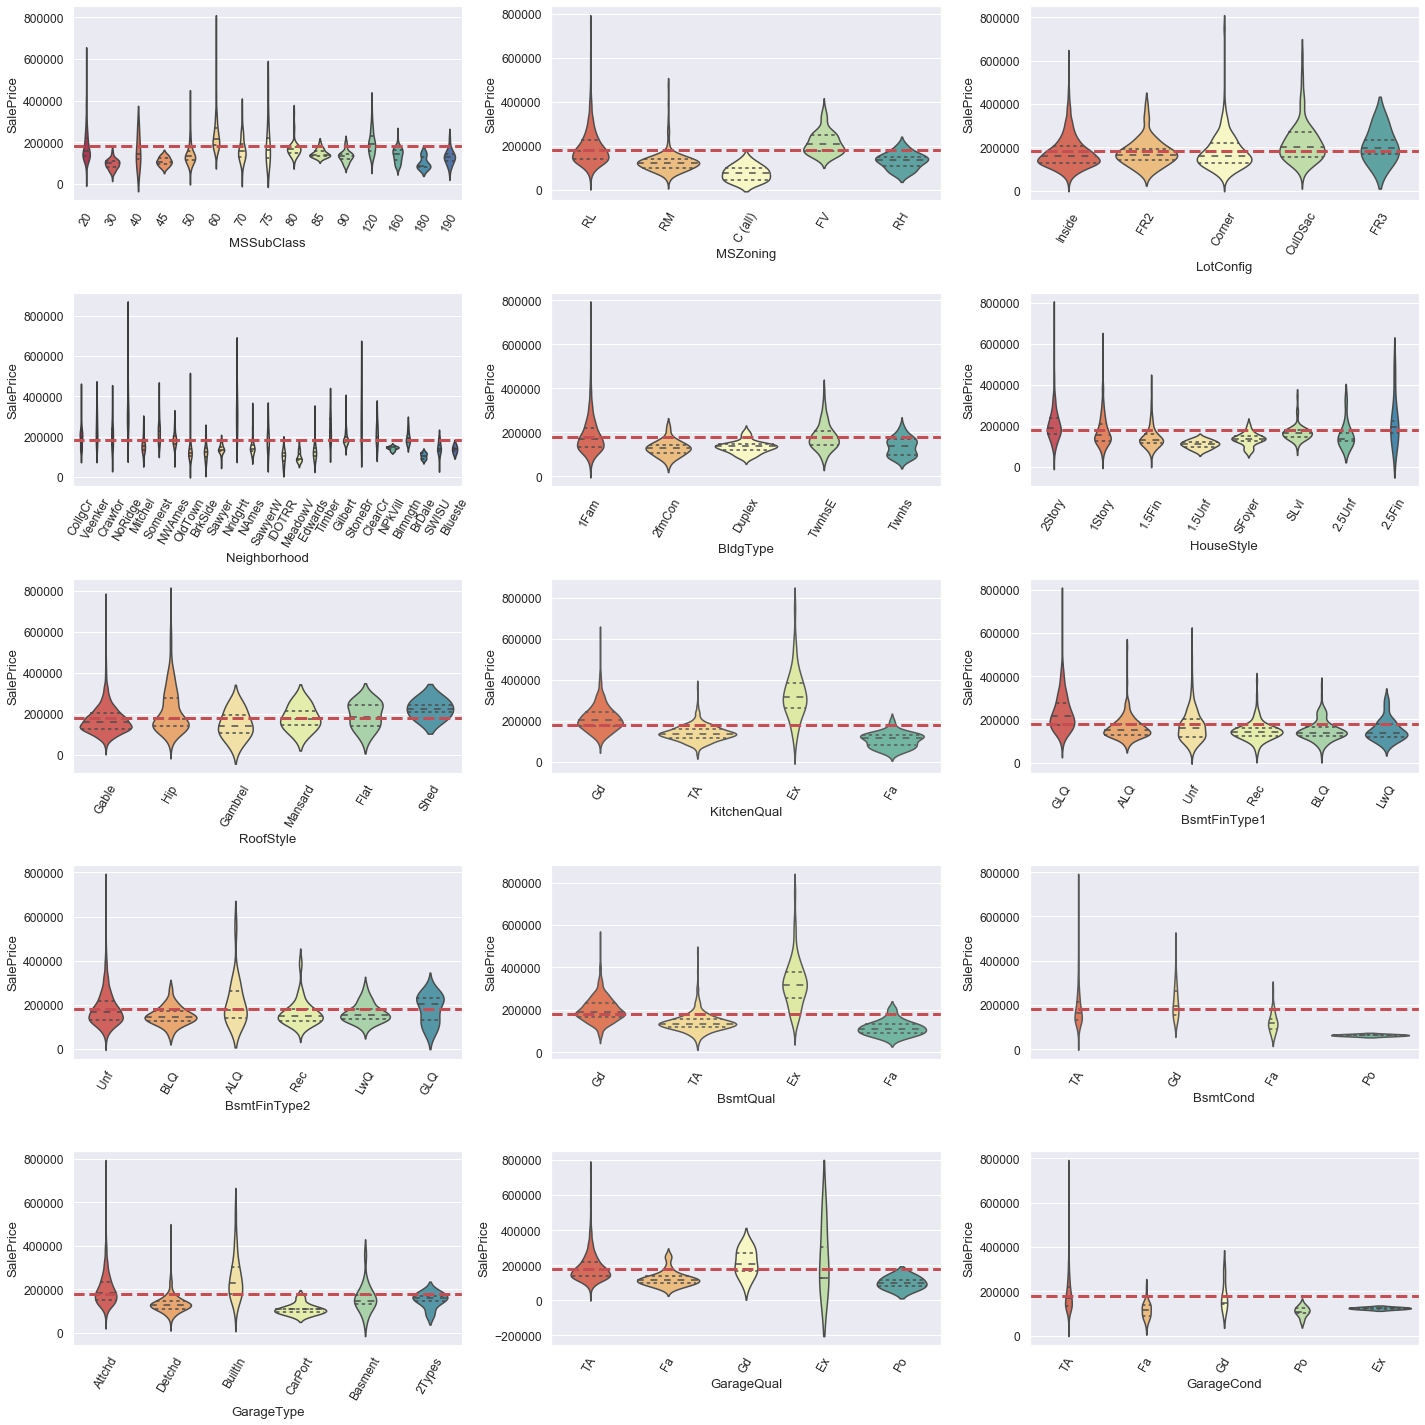

In [22]:
#Listing categorical related to sale price
objts = [
    'MSSubClass',
    'MSZoning',
    'LotConfig',
    'Neighborhood',
    'BldgType',
    'HouseStyle',
    'RoofStyle',
    'KitchenQual',
    'BsmtFinType1',
    'BsmtFinType2',
    'BsmtQual',
    'BsmtCond',
    'GarageType',
    'GarageQual',
    'GarageCond',
]

#Plotting violin plots to see relationships

fig, axes =plt.subplots(5,3, figsize=(20,20))
axes = axes.flatten()

for ax, catplot in zip(axes, objts):
    sns.violinplot(x=catplot, y='SalePrice', data=train, ax=ax, palette='Spectral', inner='quartile')
    ax.set_xticklabels(ax.get_xticklabels(),rotation=60)
    ax.axhline(train.SalePrice.mean(),color='r',linestyle='--',linewidth=3)

plt.tight_layout()  
plt.show()

In [23]:
#Creating new features by merging closely related ones
features['YrBltAndRemod'] = features['YearBuilt'] + features['YearRemodAdd']

features['TotalSF'] = features['TotalBsmtSF'] + features[
    '1stFlrSF'] + features['2ndFlrSF']

features['Total_sqr_footage'] = (features['BsmtFinSF1'] +
                                 features['BsmtFinSF2'] +
                                 features['1stFlrSF'] + features['2ndFlrSF'])
#Gave weights for half baths and basement half baths
features['Total_Bathrooms'] = (features['FullBath'] +
                               (0.5 * features['HalfBath']) +
                               features['BsmtFullBath'] +
                               (0.5 * features['BsmtHalfBath']))

features['Total_porch_sf'] = (features['OpenPorchSF'] + features['3SsnPorch'] +
                              features['EnclosedPorch'] +
                              features['ScreenPorch'] + features['WoodDeckSF'])

#Merging quality and conditions
features['TotalQual'] = (features['OverallQual'] + features['OverallCond'])

#Creating new features by using new quality feature
features['QualSF'] = features['TotalQual'] * features['TotalSF']

features['QlLivArea'] = (features['GrLivArea'] - features['LowQualFinSF'])/(1-features['TotalQual'])


In [24]:
#Creating new features by categorizing specific area metrics
features['haspool'] = features['PoolArea'].apply(lambda x: 'Y' if x > 0 else 'N')
features['has2ndfloor'] = features['2ndFlrSF'].apply(lambda x: 'Y' if x > 0 else 'N')
features['hasgarage'] = features['GarageArea'].apply(lambda x: 'Y' if x > 0 else 'N')
features['hasbsmt'] = features['TotalBsmtSF'].apply(lambda x: 'Y' if x > 0 else 'N')
features['hasfireplace'] = features['Fireplaces'].apply(lambda x: 'Y' if x > 0 else 'N')

In [25]:
#Splitting features after feature engineering because going to drop outliers from train data
train = features.iloc[:len(y), :]
test = features.iloc[len(train):, :]

#Backing up target variables
train['SalePrice'] = y

#Listing pearson corr's with revised features
train_corr = train.corr().abs().unstack().sort_values(
    kind='quicksort', ascending=False).reset_index()
train_corr.rename(columns={
    'level_0': 'Feature A',
    'level_1': 'Feature B',
    0: 'Correlation Coefficient'
},
    inplace=True)
train_corr[(train_corr['Feature A'] == 'SalePrice') & (
    train_corr['Correlation Coefficient'] >= 0.50)].style.background_gradient(
        cmap='summer_r')


C:\Users\Revenge\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Feature A,Feature B,Correlation Coefficient
0,SalePrice,SalePrice,1.000000
56,SalePrice,QualSF,0.833964
71,SalePrice,OverallQual,0.790982
73,SalePrice,TotalSF,0.782260
88,SalePrice,GrLivArea,0.708624
91,SalePrice,Total_sqr_footage,0.708047
114,SalePrice,GarageCars,0.640409
119,SalePrice,Total_Bathrooms,0.631731
124,SalePrice,GarageArea,0.623431
130,SalePrice,TotalBsmtSF,0.613581


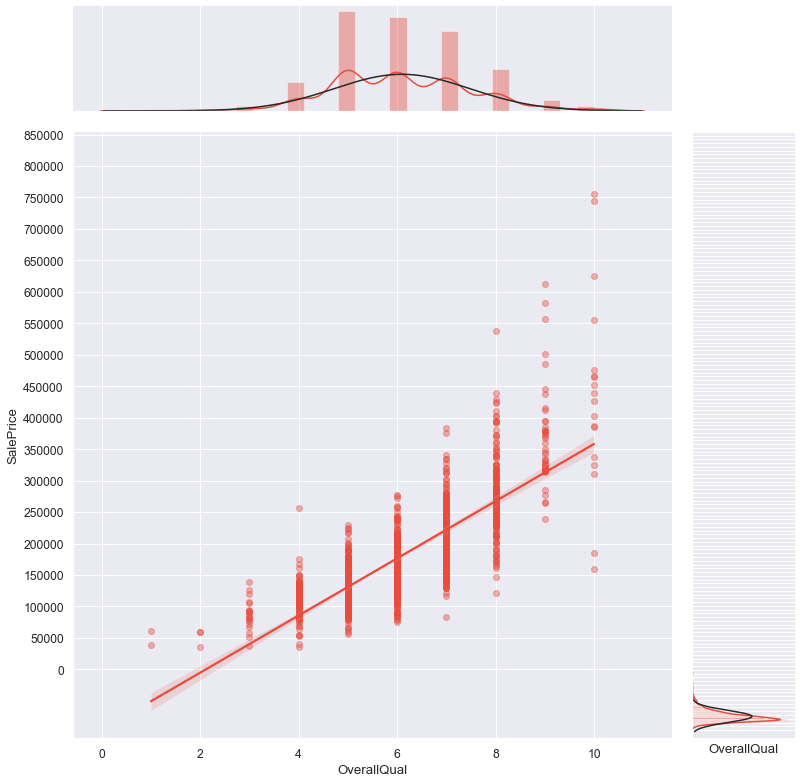

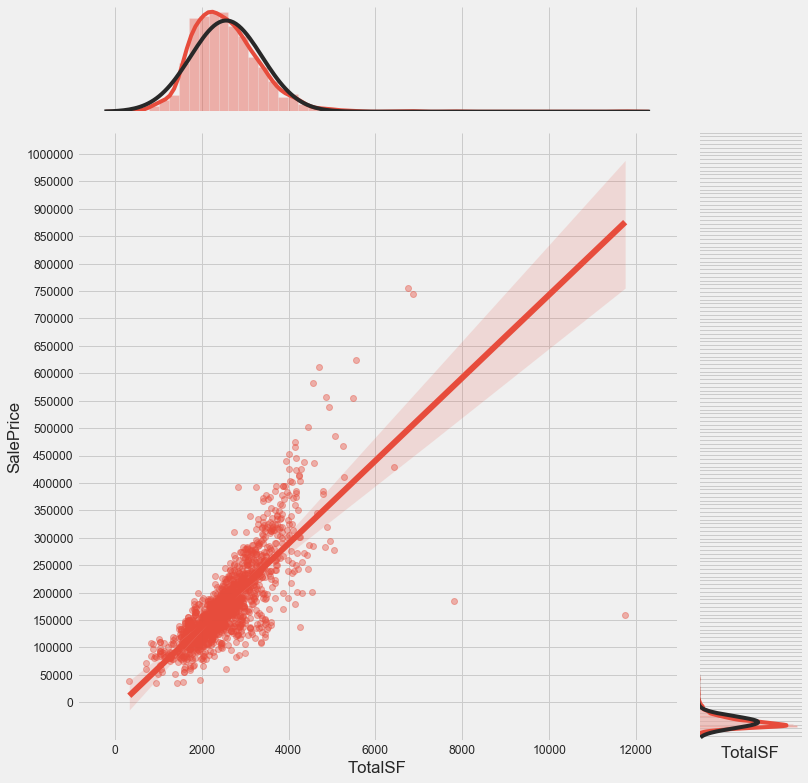

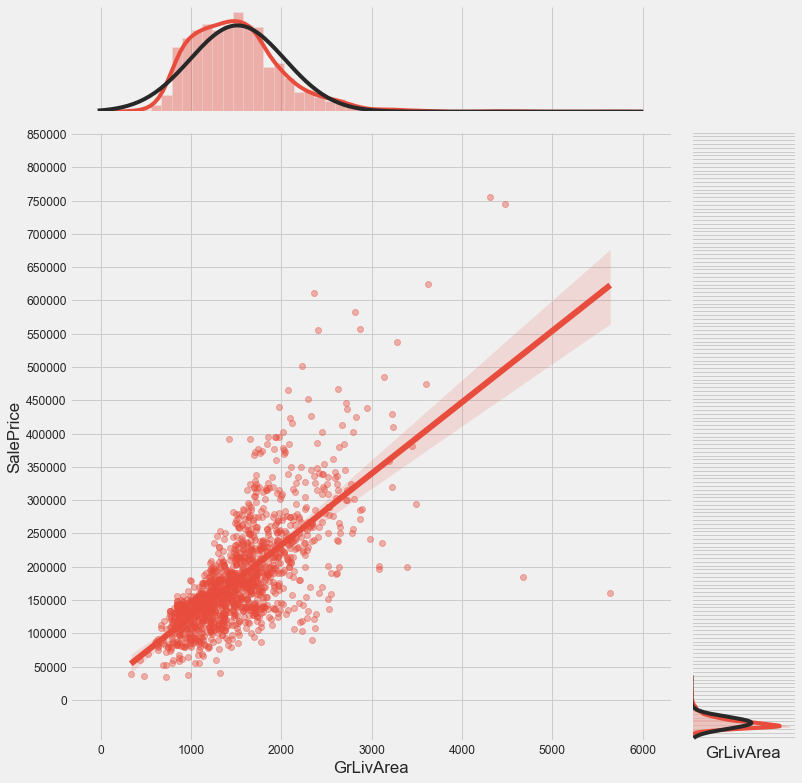

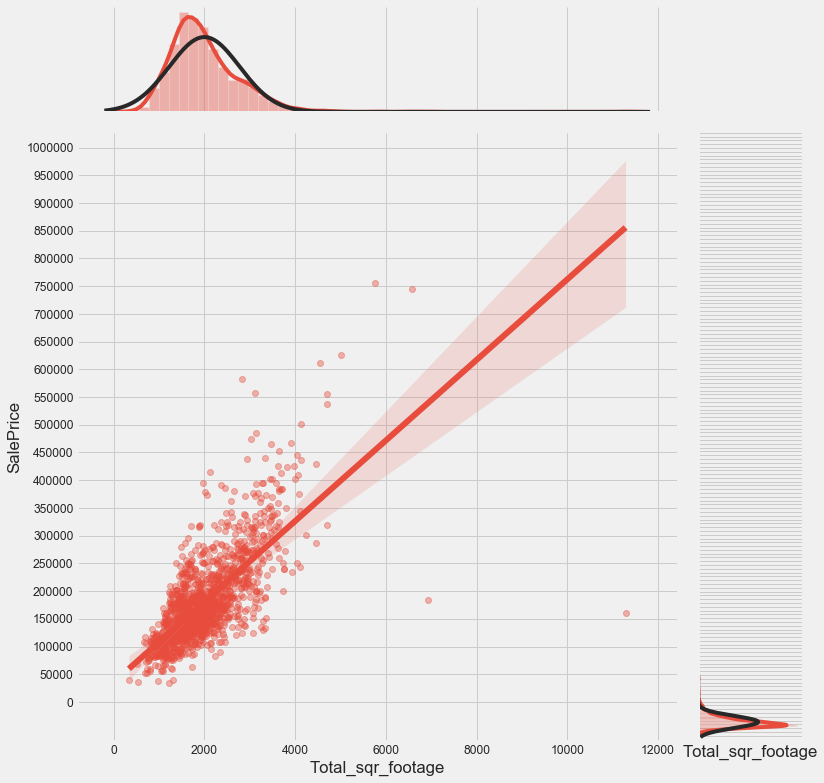

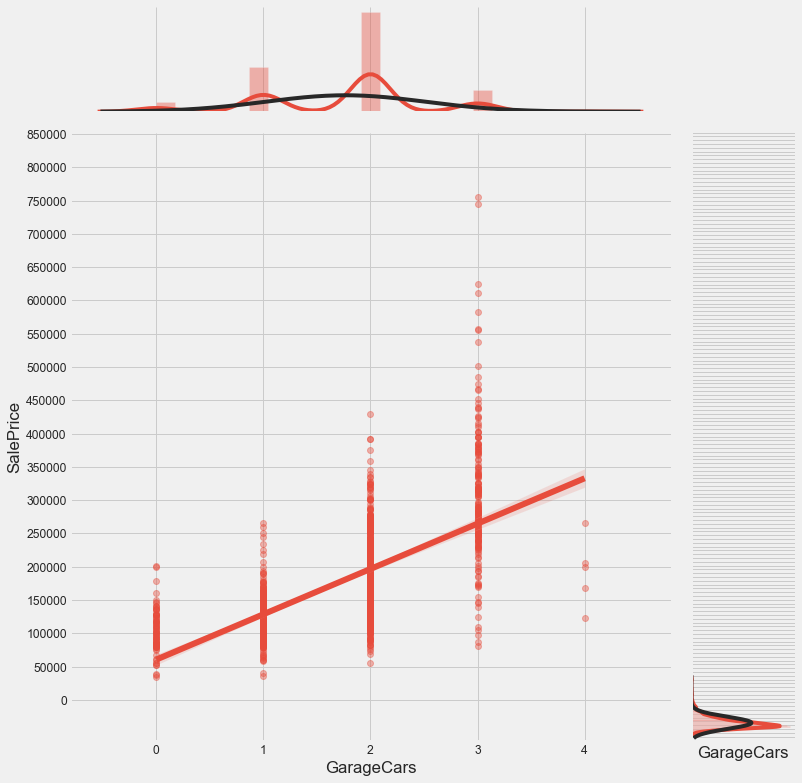

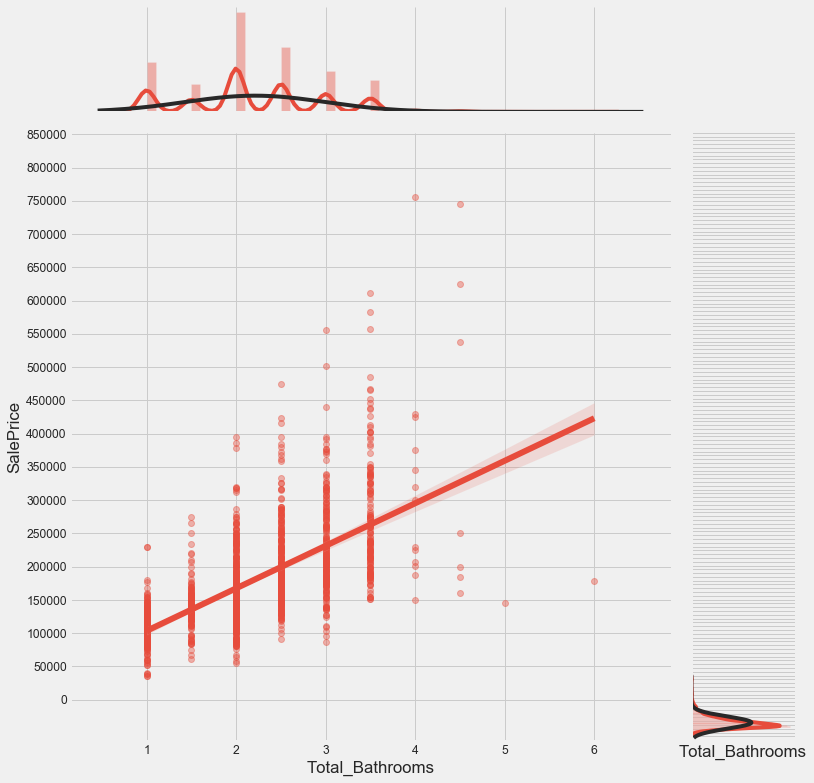

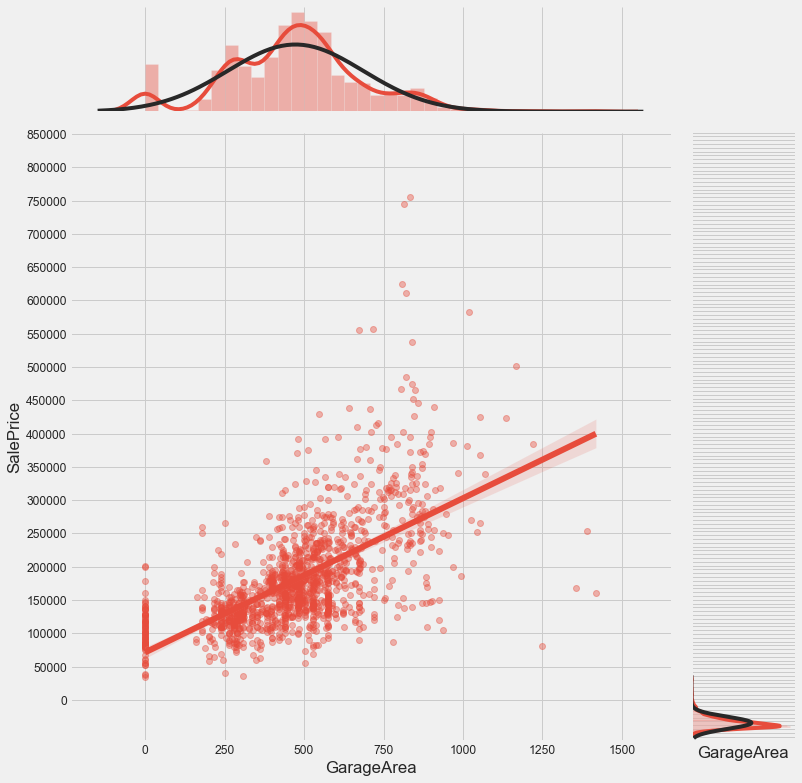

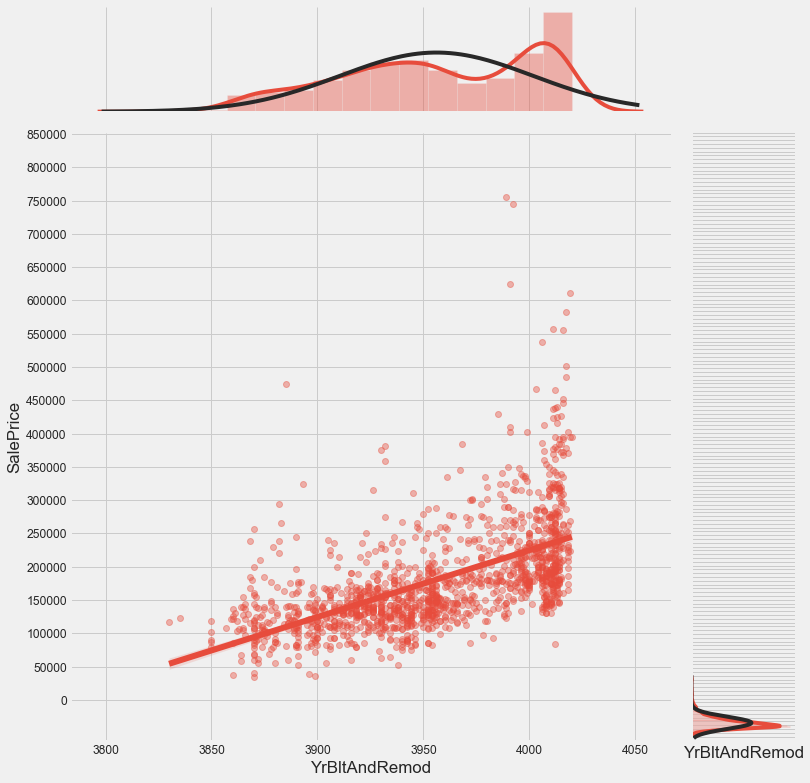

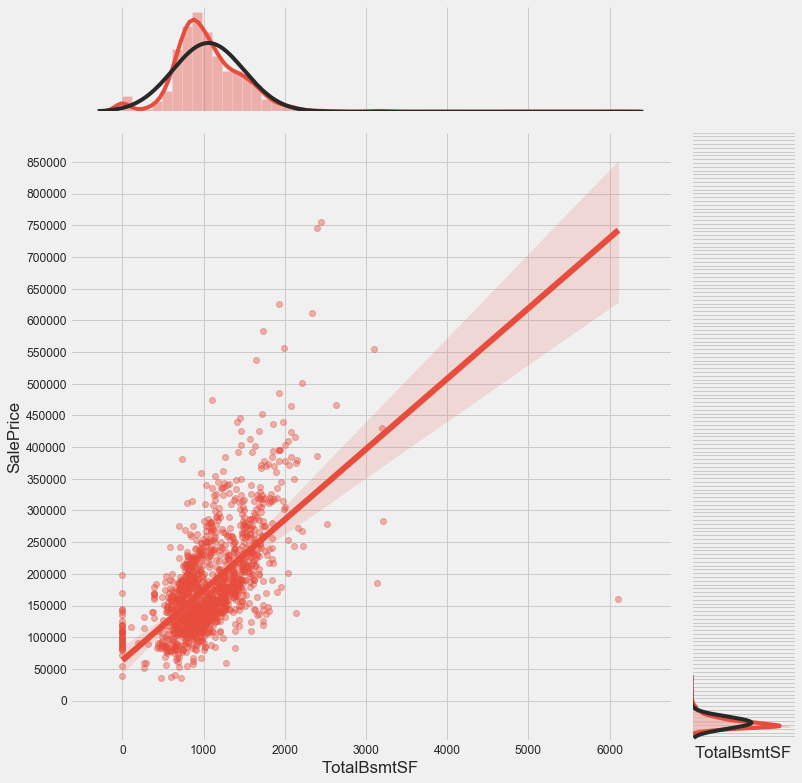

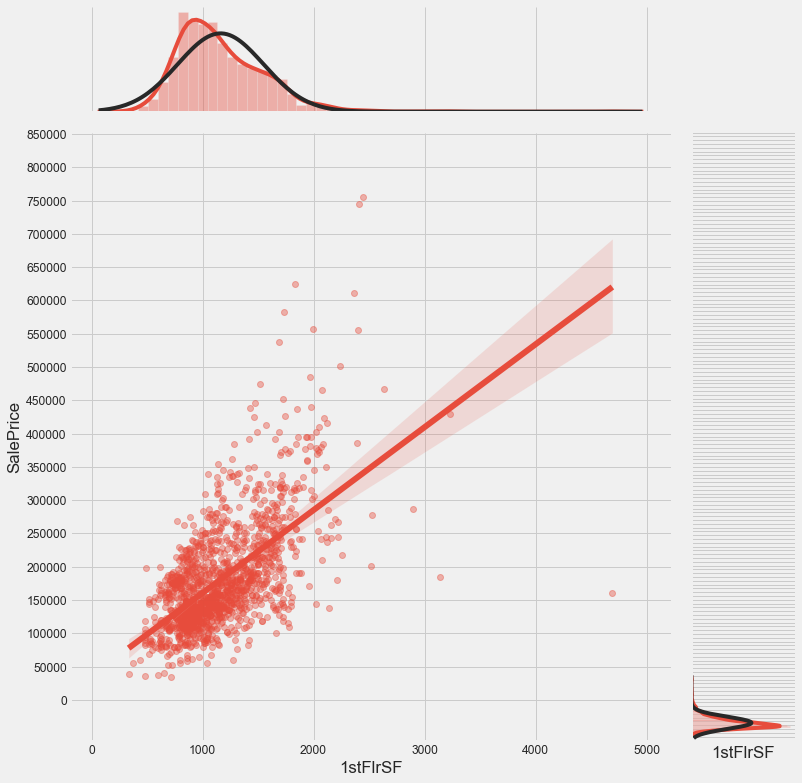

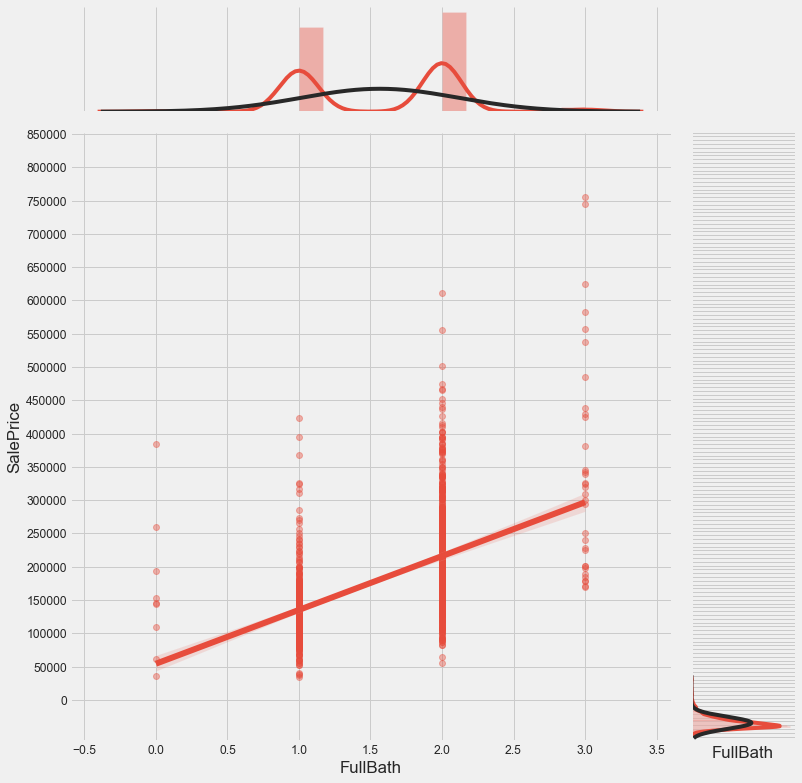

In [26]:
#Handpicking higly related features with sale price to drop outliers.
high_corr_cols = [
    'OverallQual', 'TotalSF', 'GrLivArea','Total_sqr_footage', 'GarageCars', 'Total_Bathrooms',
    'GarageArea', 'YrBltAndRemod', 'TotalBsmtSF', '1stFlrSF', 'FullBath', 
]



#Checking for outliers in related features vs SalePrice
for i in high_corr_cols:
    g = sns.JointGrid(x=i, y='SalePrice', data=train)
    g = g.plot_joint(sns.regplot, color='#e74c3c', scatter_kws={'alpha': 0.4})
    g = g.plot_marginals(sns.distplot,
                         hist=True,
                         kde=True,
                         fit=norm,
                         kde_kws={
                             'shade': False,
                             'legend': True
                         },
                         color='#e74c3c')
    plt.xlabel(str(i))
    plt.yticks(np.arange(0, 8000000, 50000))
    g.fig.set_figwidth(12)
    g.fig.set_figheight(12)
    plt.style.use('fivethirtyeight')
    plt.show()

In [27]:
#Dropping outliers after detecting them by eye
train = train.drop(train[(train.OverallQual<5) & (train.SalePrice>200000)].index)
train = train.drop(train[(train['TotalSF'] > 6000) & (train['SalePrice'] < 200000)].index)
train = train.drop(train[(train['GrLivArea'] > 4000) & (train['SalePrice'] < 200000)].index)
train = train.drop(train[(train.Total_Bathrooms>4) & (train.SalePrice<180000)].index)
train = train.drop(train[(train.Total_Bathrooms<5) & (train.SalePrice>600000)].index)
train = train.drop(train[(train.GarageArea>1200) & (train.SalePrice<100000)].index)
train = train.drop(train[(train.GarageArea<1000) & (train.SalePrice>500000)].index)
train = train.drop(train[(train.YrBltAndRemod<4000) & (train.SalePrice>450000)].index)
train = train.drop(train[(train.TotalBsmtSF<1800) & (train.SalePrice>450000)].index)
train = train.drop(train[(train.TotalBsmtSF>4000) & (train.SalePrice>200000)].index)
train = train.drop(train[(train['1stFlrSF']<3000) & (train.SalePrice>600000)].index)
train = train.drop(train[(train['1stFlrSF']>3000) & (train.SalePrice<200000)].index)
train = train.drop(train[(train.FullBath<1) & (train.SalePrice>250000)].index)

In [28]:
#Listing corr's after dropping outliers
train_corr = train.corr().abs().unstack().sort_values(
    kind='quicksort', ascending=False).reset_index()
train_corr.rename(columns={
    'level_0': 'Feature A',
    'level_1': 'Feature B',
    0: 'Correlation Coefficient'
},
    inplace=True)
train_corr[(train_corr['Feature A'] == 'SalePrice') & (
    train_corr['Correlation Coefficient'] >= 0.50)].style.background_gradient(
        cmap='summer_r')

,Feature A,Feature B,Correlation Coefficient
0,SalePrice,SalePrice,1.000000
49,SalePrice,QualSF,0.881097
58,SalePrice,TotalSF,0.820756
62,SalePrice,OverallQual,0.806129
82,SalePrice,Total_sqr_footage,0.737857
88,SalePrice,GrLivArea,0.711885
107,SalePrice,GarageCars,0.658065
110,SalePrice,GarageArea,0.648916
112,SalePrice,Total_Bathrooms,0.647970
117,SalePrice,TotalBsmtSF,0.639490


In [29]:
#Log1p-transformation of the target variable
train['SalePrice'] = np.log1p(train['SalePrice'])

#Splitting test features after dropping some outliers
test_features = features.iloc[len(y):, :]

#Backing up target variables and dropping them from train data
y = train.SalePrice.reset_index(drop=True)
train_features = train.drop(['SalePrice'], axis=1)

#Merging features for the last time for transforming skewed features
features = pd.concat([train_features, test_features]).reset_index(drop=True)

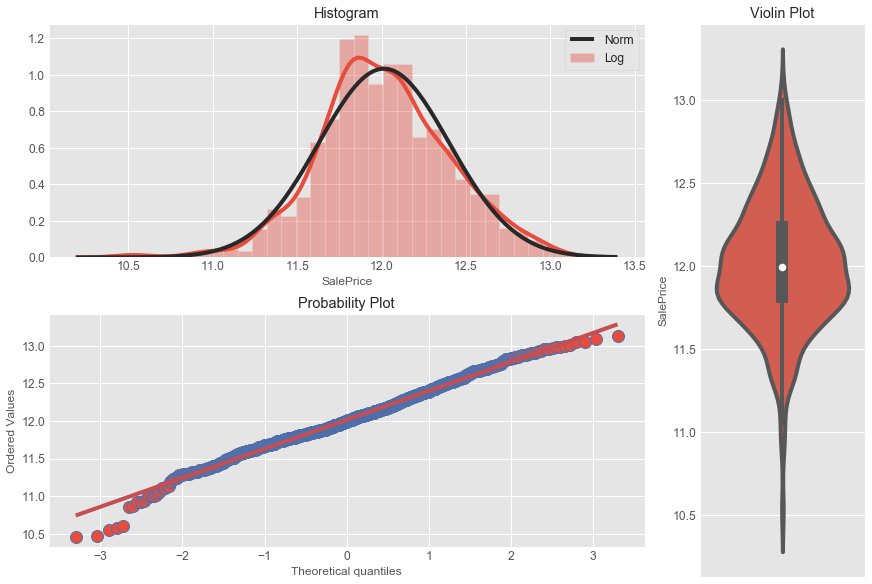

In [30]:
#Showing empirical target data set vs theororetical set after transforming target variables

def plot_3chart(df, feature):
    import matplotlib.gridspec as gridspec
    plt.style.use('ggplot')
    # Creating a customized chart. and giving in figsize and everything. 
    fig = plt.figure(constrained_layout=True, figsize=(12,8))
    # creating a grid of 3 cols and 3 rows. 
    grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)

    ## Customizing the histogram grid. 
    ax1 = fig.add_subplot(grid[0, :2])
    # Set the title. 
    ax1.set_title('Histogram')
    # plot the histogram. 
    sns.distplot(df.loc[:,feature], hist=True,kde=True,fit=norm, ax = ax1,color='#e74c3c')
    ax1.legend(labels=['Norm','Log'])
    
    # customizing the QQ_plot. 
    ax2 = fig.add_subplot(grid[1, :2])
    # Set the title. 
    ax2.set_title('Probability Plot')
    # Plotting the QQ_Plot. 
    stats.probplot(df.loc[:,feature], plot = ax2)
    ax2.get_lines()[0].set_markerfacecolor('#e74c3c')
    ax2.get_lines()[0].set_markersize(12.0)
    

    # Customizing the Box Plot. 
    ax3 = fig.add_subplot(grid[:, 2])
    # Set title. 
    ax3.set_title('Violin Plot')
    # Plotting the box plot. 
    sns.violinplot(df.loc[:,feature], orient='v', ax = ax3,color='#e74c3c');
    
plot_3chart(train, 'SalePrice')

In [31]:
#Taking out list of numerical data:
numerics = [i for i in features.columns if features.dtypes[i] != 'object']

#Finding skewness of the numerical features
skew_features = features[numerics].apply(lambda x: skew(x)).sort_values(
    ascending=False)

#Filtering skewed features
high_skew = skew_features[skew_features > 0.5]

#Taking indexes of high skew
skew_index = high_skew.index

#Applying boxcox transformation to fix skewness
for i in skew_index:
    features[i] = boxcox1p(features[i], boxcox_normmax(features[i] + 1))

#Dropping irrevelant features
features = features.drop([
    'Utilities',
    'Street',
    'PoolQC',
], axis=1)

C:\Users\Revenge\anaconda3\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\Revenge\anaconda3\lib\site-packages\scipy\stats\stats.py:3538: PearsonRNearConstantInputWarning: An input array is nearly constant; the computed correlation coefficent may be inaccurate.
  warnings.warn(PearsonRNearConstantInputWarning())


In [32]:
#Getting final features by one hot encoding
print(features.shape)
final_features = pd.get_dummies(features).reset_index(drop=True)
print(final_features.shape)

(2901, 89)
(2901, 341)


In [33]:
#Splitting train and test data for the last time
X_train = final_features.iloc[:len(y), :]
X_test = final_features.iloc[len(X_train):, :]

print('X', X_train.shape, 'y', y.shape, 'X_test', X_test.shape)

X (1442, 341) y (1442,) X_test (1459, 341)


In [34]:
#Detecting overfitting columns
overfit = []
for i in X_train.columns:
    counts = X_train[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(X_train) * 100 > 99.94:
        overfit.append(i)

In [35]:
#Dropping overfitting columns
overfit = list(overfit)
overfit.append('MSZoning_C (all)')
#
X_train = X_train.drop(overfit, axis=1).copy()
X_test = X_test.drop(overfit, axis=1).copy()
#
print('X', X_train.shape, 'y', y.shape, 'X_test', X_test.shape)

X (1442, 339) y (1442,) X_test (1459, 339)


In [36]:
nfolds = 10
kf = KFold(nfolds, shuffle=True, random_state=42)


# rmsle_cv
def rmsle_cv(model, trainx, trainy):
    rmse = np.sqrt(np.abs(cross_val_score(model,
                                          trainx.values,
                                          trainy,
                                          scoring='neg_mean_squared_error',
                                          cv=kf,
                                          n_jobs=-1)))
    return (rmse)


# rmsle
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

#r2 is optinal not added yet
def r2_cv(model, trainx, trainy):
    rtw = cross_val_score(model,
                          trainx.values,
                          trainy,
                          scoring='neg_mean_squared_error',
                          cv=kf,
                          n_jobs=-1)
    return (rtw)

In [37]:
alphas_alt = [27.5, 27.6, 27.7, 27.8, 27.9, 27, 27.1, 27.2, 27.3, 27.4, 27.5]
alphas2 = [
    5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008
]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]



#ridge_cv
ridge = make_pipeline(RobustScaler(), RidgeCV(
    alphas=alphas_alt,
    cv=kf,
))

#lasso_cv
lasso = make_pipeline(
    RobustScaler(),
    LassoCV(max_iter=1e7, alphas=alphas2, random_state=42, cv=kf))

#elasticnet_cv
elasticnet = make_pipeline(
    RobustScaler(),
    ElasticNetCV(max_iter=1e7,
                 alphas=e_alphas,
                 cv=kf,
                 random_state=42,
                 l1_ratio=e_l1ratio))

#svr
svr = make_pipeline(RobustScaler(), SVR(
    C=21,
    epsilon=0.0099,
    gamma=0.00017,
    tol = 0.000121
))

#gradientboosting
gbr = GradientBoostingRegressor(n_estimators=2900,
                                learning_rate=0.0161,
                                max_depth=4,
                                max_features='sqrt',
                                min_samples_leaf=17,
                                loss='huber',
                                random_state=42)

#lightgbm
lightgbm = LGBMRegressor(
    objective='regression',
    n_estimators= 3500,
    num_leaves= 5,
    learning_rate= 0.00721,
    max_bin= 163,
    bagging_fraction= 0.35711,
    n_jobs=-1,
    bagging_seed=42,
    feature_fraction_seed=42,
    bagging_freq= 7,
    feature_fraction= 0.1294,
    min_data_in_leaf= 8
    
)



#xgboost
xgboost = XGBRegressor(learning_rate=0.0139,
                       n_estimators=4500,
                       max_depth=4,
                       min_child_weight=0,
                       subsample=0.7968,
                       colsample_bytree=0.4064,
                       nthread=-1,
                       scale_pos_weight=2,
                       seed=42,
                          )

#stack
stack_gen = StackingCVRegressor(regressors=(ridge, lasso, elasticnet, gbr,
                                            xgboost, lightgbm),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)
#models to crossval and fit
mods = [ridge, lasso, elasticnet, svr, gbr, lightgbm, xgboost]

In [38]:
mod_name = []
rms = []
rmstd = []

#executing models
for i in mods:
    score = rmsle_cv(i, X_train, y)
    mod_name.append(i)
    rms.append(score.mean())
    rmstd.append(score.std())

#creating a data frame out of crossval results
model_df = pd.DataFrame(list(zip(mod_name, rms, rmstd)),
                        columns=['Model', 'Rmsle', 'Rmsle Std'])

display(
    model_df.sort_values(by='Rmsle', ascending=True).reset_index(
        drop=True).style.background_gradient(cmap='summer'))

,Model,Rmsle,Rmsle Std
0,"Pipeline(memory=None, steps=[('robustscaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True, with_scaling=True)), ('svr', SVR(C=21, cache_size=200, coef0=0.0, degree=3, epsilon=0.0099, gamma=0.00017, kernel='rbf', max_iter=-1, shrinking=True, tol=0.000121, verbose=False))], verbose=False)",0.107200,0.016837
1,"GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse', init=None, learning_rate=0.0161, loss='huber', max_depth=4, max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=17, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=2900, n_iter_no_change=None, presort='deprecated', random_state=42, subsample=1.0, tol=0.0001, validation_fraction=0.1, verbose=0, warm_start=False)",0.109173,0.016886
2,"Pipeline(memory=None, steps=[('robustscaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True, with_scaling=True)), ('ridgecv', RidgeCV(alphas=array([27.5, 27.6, 27.7, 27.8, 27.9, 27. , 27.1, 27.2, 27.3, 27.4, 27.5]), cv=KFold(n_splits=10, random_state=42, shuffle=True), fit_intercept=True, gcv_mode=None, normalize=False, scoring=None, store_cv_values=False))], verbose=False)",0.109295,0.016148
3,"LGBMRegressor(bagging_fraction=0.35711, bagging_freq=7, bagging_seed=42, boosting_type='gbdt', class_weight=None, colsample_bytree=1.0, feature_fraction=0.1294, feature_fraction_seed=42, importance_type='split', learning_rate=0.00721, max_bin=163, max_depth=-1, min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=8, min_split_gain=0.0, n_estimators=3500, n_jobs=-1, num_leaves=5, objective='regression', random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0, subsample_for_bin=200000, subsample_freq=0)",0.110316,0.017107
4,"Pipeline(memory=None, steps=[('robustscaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True, with_scaling=True)), ('lassocv', LassoCV(alphas=[5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008], copy_X=True, cv=KFold(n_splits=10, random_state=42, shuffle=True), eps=0.001, fit_intercept=True, max_iter=10000000.0, n_alphas=100, n_jobs=None, normalize=False, positive=False, precompute='auto', random_state=42, selection='cyclic', tol=0.0001, verbose=False))], verbose=False)",0.110544,0.016017
5,"Pipeline(memory=None, steps=[('robustscaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True, with_scaling=True)), ('elasticnetcv', ElasticNetCV(alphas=[0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007], copy_X=True, cv=KFold(n_splits=10, random_state=42, shuffle=True), eps=0.001, fit_intercept=True, l1_ratio=[0.8, 0.85, 0.9, 0.95, 0.99, 1], max_iter=10000000.0, n_alphas=100, n_jobs=None, normalize=False, positive=False, precompute='auto', random_state=42, selection='cyclic', tol=0.0001, verbose=0))], verbose=False)",0.110703,0.016180
6,"XGBRegressor(base_score=None, booster=None, colsample_bylevel=None, colsample_bynode=None, colsample_bytree=0.4064, gamma=None, gpu_id=None, importance_type='gain', interaction_constraints=None, learning_rate=0.0139, max_delta_step=None, max_depth=4, min_child_weight=0, missing=nan, monotone_constraints=None, n_estimators=4500, n_jobs=None, nthread=-1, num_parallel_tree=None, objective='reg:squarederror', random_state=None, reg_alpha=None, reg_lambda=None, scale_pos_weight=2, seed=42, subsample=0.7968, tree_method=None, validate_parameters=False, verbosity=None)",0.113960,0.018245


In [39]:
#Fitting models including stack

print('='*20,'START Fitting','='*20)
print('='*55)
print(datetime.now(), 'StackingCVRegressor')
stack_gen_model = stack_gen.fit(np.array(X_train), np.array(y))
print(datetime.now(), 'Elasticnet')
elastic_model_full_data = elasticnet.fit(X_train, y)
print(datetime.now(), 'Lasso')
lasso_model_full_data = lasso.fit(X_train, y)
print(datetime.now(), 'Ridge')
ridge_model_full_data = ridge.fit(X_train, y)
print(datetime.now(), 'SVR')
svr_model_full_data = svr.fit(X_train, y)
print(datetime.now(), 'GradientBoosting')
gbr_model_full_data = gbr.fit(X_train, y)
print(datetime.now(), 'XGboost')
xgb_model_full_data = xgboost.fit(X_train, y)
print(datetime.now(), 'Lightgbm')
lgb_model_full_data = lightgbm.fit(X_train, y)
print('='*20,'FINISHED Fitting','='*20)
print('='*58)

==================== START Fitting ====================
2020-05-01 00:48:11.279865 StackingCVRegressor
2020-05-01 00:51:56.407245 Elasticnet
2020-05-01 00:52:07.509663 Lasso
2020-05-01 00:52:11.336569 Ridge
2020-05-01 00:52:12.488705 SVR
2020-05-01 00:52:13.136497 GradientBoosting
2020-05-01 00:52:19.873656 XGboost
2020-05-01 00:52:32.842269 Lightgbm
==================== FINISHED Fitting ====================


In [40]:
#defining weights for the models

def blend_models_predict(X):
    return ((0.1 * elastic_model_full_data.predict(X)) +
            (0.05 * lasso_model_full_data.predict(X)) +
            (0.1 * ridge_model_full_data.predict(X)) +
            (0.1 * svr_model_full_data.predict(X)) +
            (0.1 * gbr_model_full_data.predict(X)) +
            (0.15 * xgb_model_full_data.predict(X)) +
            (0.1 * lgb_model_full_data.predict(X)) +
            (0.3 * stack_gen_model.predict(np.array(X))))

In [41]:
print('RMSLE score on train data:')
print(rmsle(y, blend_models_predict(X_train)))

RMSLE score on train data:
0.052852490215452644


In [42]:
print(
    'Predict submission',
    datetime.now(),
)

#Reading test data to add model predictions
submission = pd.read_csv('test.csv')
#Inversing and flooring log scaled sale price predictions
submission['SalePrice'] = np.floor(np.expm1(blend_models_predict(X_test)))

Predict submission 2020-05-01 00:52:34.410480


In [43]:
#defining outlier quartile ranges
q1 = submission['SalePrice'].quantile(0.0050)
q2 = submission['SalePrice'].quantile(0.99)

#applying weights to outlier ranges to smooth them
submission['SalePrice'] = submission['SalePrice'].apply(
    lambda x: x if x > q1 else x * 0.77)
submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x
                                                        if x < q2 else x * 1.1)
submission = submission[['Id', 'SalePrice']]

#saving submission csv

submission.to_csv('mysubmission.csv', index=False)
print(
    'Save submission',
    datetime.now(),
)

Save submission 2020-05-01 00:52:35.440656
